<IPython.core.display.Javascript object>


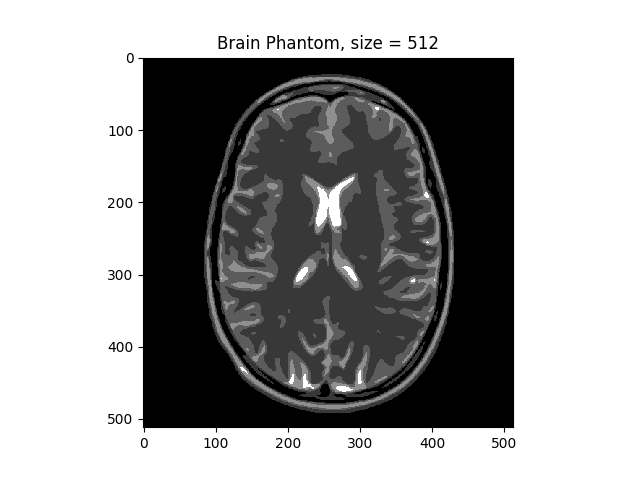

In [42]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd,"data")
img_size = 512   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

<IPython.core.display.Javascript object>


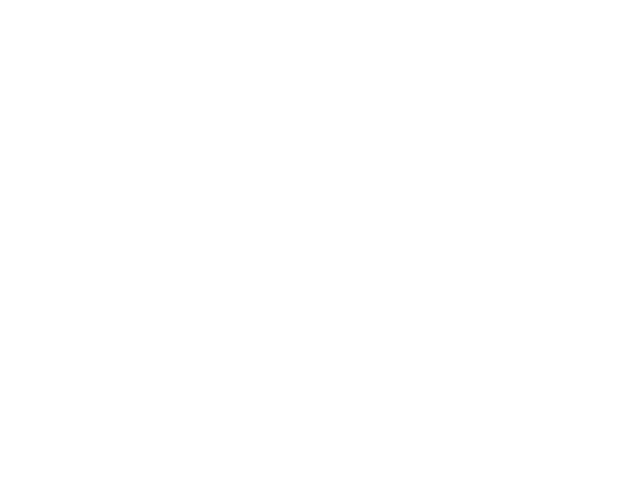

<IPython.core.display.Javascript object>


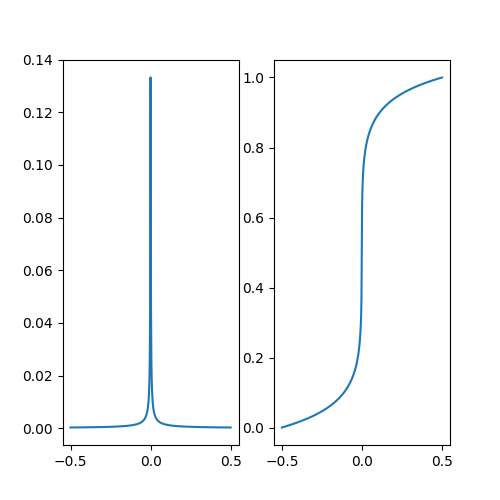

128
[255 173 256  27 507 466 255 255 255 257 286 197 262 264 255 254 255 257
 249 209 255 306 238 256 245 102 255 251 255 255 255 255 254 253 155 238
 255 255 297 255 200 253 206 120 255 274 138 255  15 265 462 164 258 412
 237 289 308 255 254 477 251 276 259 111 258 255 257 255 255 258 346 278
 344 174 374 254 255 255 252 260 288 272 246 291 252  73 344 145 169 255
 250 254 257 255 282 290 255 442 256 255 255 350 256 255 255 264 249 250
 251 453 241 255 351 273 264 257 255 267 446 200 204 257 261 251 255 264
 278 396]


<IPython.core.display.Javascript object>


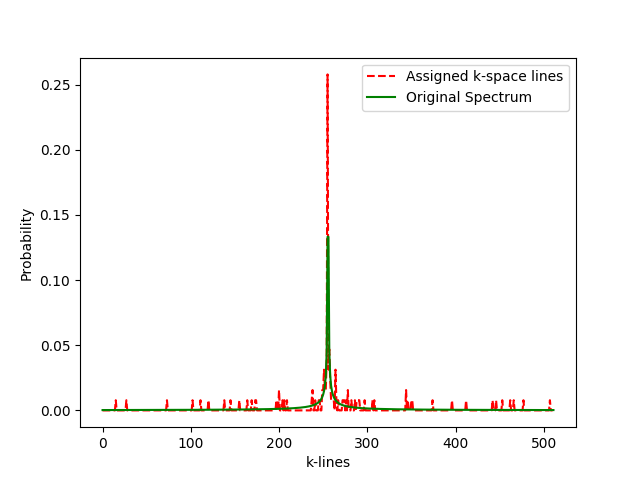

[ 15  27  73 102 111 120 138 145 155 164 169 173 174 197 200 204 206 209
 237 238 241 245 246 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 264 265 267 272 273 274 276 278 282 286 288 289 290 291 297 306 308
 344 346 350 351 374 396 412 442 446 453 462 466 477 507]
68


<IPython.core.display.Javascript object>


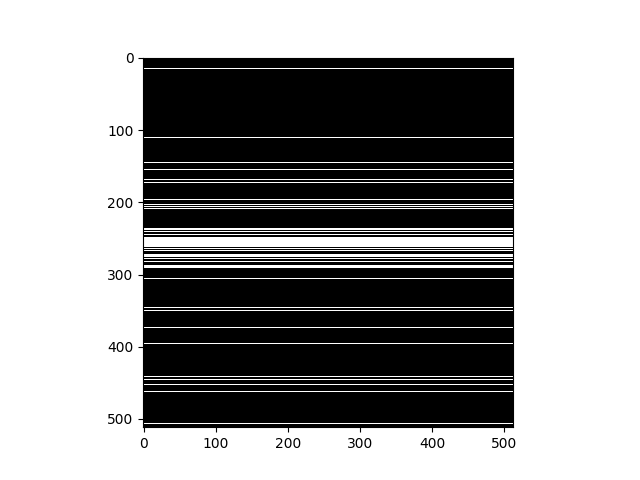

In [43]:
import numpy as np
import sys
import numpy.random as ra

eps = sys.float_info.epsilon
#img_size = 512
# generate Cartesian lines in a straightforward manner
#a = np.linspace(0,img_size,img_size)
a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
 

c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
#kspace_lines = np.linspace(-1/2., 1/2.,img_size)
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
#p_decay = np.power(np.abs(kspace_lines+eps),-decay)
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(x, p_decay)
axs[1].plot(x, cdf_pdecay)

nb_samples = (int)(img_size/4)
print(nb_samples)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]
#print(samples)
#print(gen_klines)

# shift the samples lines by half of the k-space (ie image size as we're in Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
#gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int)
print(gen_klinesb)   # unsorted samples
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

# check histogram of samples value to see whether it fits the prescribed density
plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()


#print("pmax = %1.3f" %pmax)
#print("pmin = %1.5f" %pmin)
#idx_max = np.where(p_decay == pmax)
#idx_min = np.where(p_decay == pmin)

#print(p_decay.min())
sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)
#print(sampled_klines.shape)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")


#fig, axs = plt.subplots(1, 2, figsize=(5, 5) )
plt.figure()
plt.imshow(kspace_mask, cmap='Greys_r')
plt.show()
#axs[0].set_title("Cartesian sampling mask (R=2)")
#axs[1].imshow(kspace_mask_r4, cmap='Greys_r')
#axs[1].set_title("Cartesian sampling mask (R=4)")


<IPython.core.display.Javascript object>


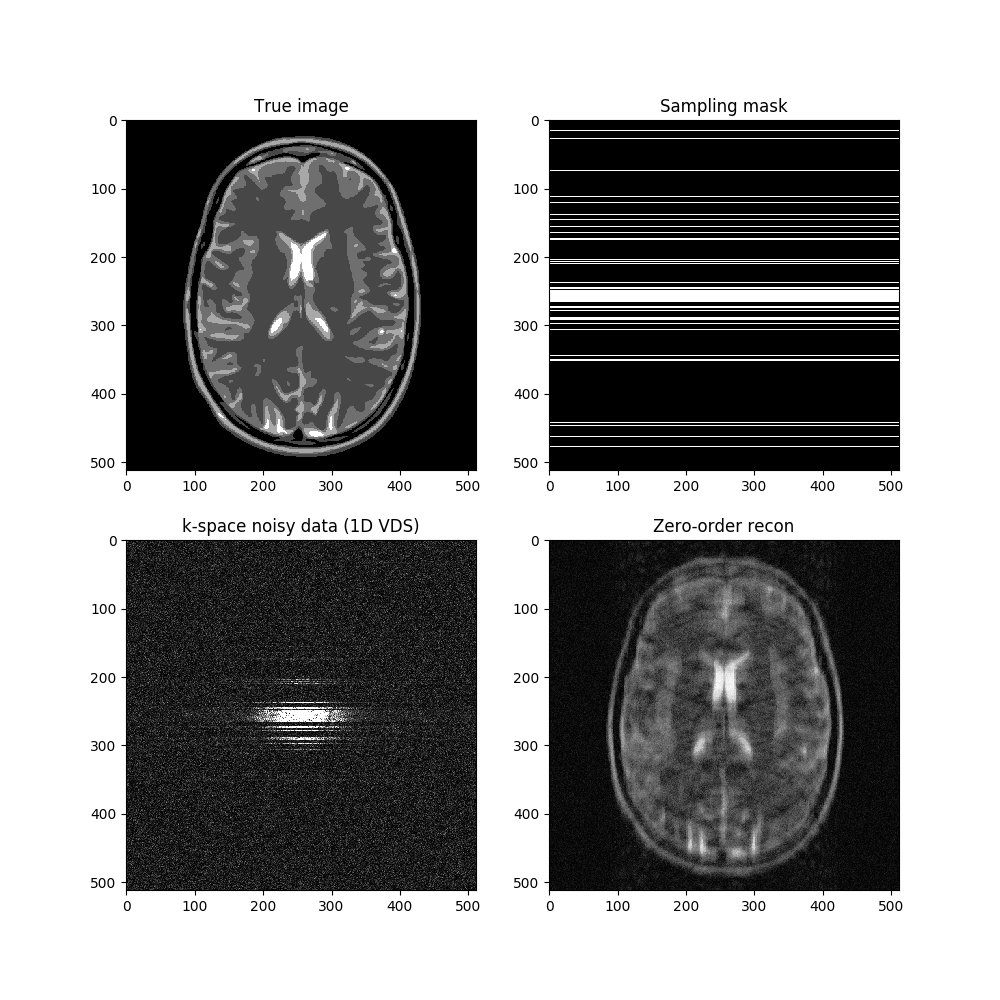

In [47]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the subsampled kspace according to the sampled lines
kspace_data = np.fft.fftshift(fft(mri_img)) * kspace_mask   # put the 0-freq in the middle of axes as

#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.005*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (1D VDS)")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()
